# MVP

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### First we load the data, which is already splitted on train, validation and test sets. We do not load test data, as we won't look at it until the end of the project.

In [2]:
def load_datasets(parquets_folder,load_test=False):    
    
    path= parquets_folder+'/'
    filenames = ['hospital_train_data.parquet','hospital_val_data.parquet','hospital_test_data.parquet']

    for file in filenames:
        if not os.path.isfile(path+file):
            print(file, 'not available in the specified folder')
        else:
            if '_train_' in file and not load_test:
                print('Loading dataset: ',file)
                train_data = pd.read_parquet(path+file)
            elif '_val_' in file and not load_test:
                print('Loading dataset: ',file)
                val_data = pd.read_parquet(path+file)
            elif '_test_' in file and load_test:
                print('Loading dataset: ',file)
                test_data = pd.read_parquet(path+file)
        
    return (train_data,val_data) if not load_test else test_data             

In [3]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/A-Machine-Learning-Approach-for-Prediction-of-Hospital-Bed-Availability/

/Users/josefinadallavia/Documents/MIM/Tesis/A-Machine-Learning-Approach-for-Prediction-of-Hospital-Bed-Availability


In [4]:
train_set, val_set = load_datasets('data/hospital_dataset')

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet


#### Feature selection & feature engineering

##### We need to choose the features we're going to train out model with. As a rule of thumb, in this first experiment, we'll use all the numerical features plus only the categorical features with less than 10 categories (as they're easier to encode)

In [6]:
train_set['admission_weekday'] = pd.to_datetime(train_set['admission_date']).dt.weekday.astype('str')
train_set['date_weekday'] = pd.to_datetime(train_set['date']).dt.weekday.astype('str')

In [7]:
val_set['admission_weekday'] = pd.to_datetime(val_set['admission_date']).dt.weekday.astype('str')
val_set['date_weekday'] = pd.to_datetime(val_set['date']).dt.weekday.astype('str')

In [8]:
categorical = []
numerical = []
for col in train_set:
    if train_set[col].dtype == 'object':
        if train_set[col].nunique() < 10:
            categorical.append(col)
    elif train_set[col].dtype in ['float', 'int'] and col != 'discharge':
        numerical.append(col)

In [ ]:
for col in categorical:
    
    X_train[col] = X_train[col].astype('category')
    X_train[col] = pd.Categorical(X_train[col].cat.codes+1)
    
    X_val[col] = X_val[col].astype('category')
    X_val[col] = pd.Categorical(X_val[col].cat.codes+1)

####  We'll model the problem as a classification problem where our target is the variable indicating wether the patient was discharged on that day (=1) or not (=0).

In [ ]:
y_train = train_set['discharge']
y_val = val_set['discharge']

In [ ]:
X_train = train_set.drop('discharge',axis=1)
X_val = val_set.drop('discharge',axis=1)

#### As a first approach we'll use lightgbm which uses decision trees on a boosting ensemble schema. The selection of the algorythmn responds primaryly to efficiences in the handling of the data that makes training extremly fast. Later on other algorythns will be tested.

In [11]:
import lightgbm as lgb

In [23]:
train_data = lgb.Dataset(X_train[categorical+numerical], 
                         label=y_train, 
                         feature_name=categorical+numerical, 
                         categorical_feature=categorical,
                        free_raw_data=False)

In [24]:
validation_data = lgb.Dataset(X_val[categorical+numerical], 
                              label=y_val, 
                              reference=train_data,
                              feature_name=categorical+numerical, 
                              categorical_feature=categorical,
                              free_raw_data=False)

In [25]:
train_data.save_binary('data/hospital_dataset/train.bin')
validation_data.save_binary('data/hospital_dataset/validation.bin')

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].cat.set_categories(category)


#### Model configuration.
At this instance, we'll use static models params. Later on model selection techniques will be used in order to find the optimal combination of parameters.
Its importance to notice that we are working with unbalanced data, we'll make this explicitly to the lgbm so that it takes into account during learning. 
As a performance metric, for now we'll use AUC-roc. This is a classification metric that has several advantages over accuracy when dealing with unbalanced classes. We may decide later on to build our own performance metric for this problem. But at this point we'll be satisfied with AUC-roc

In [57]:
y_train.value_counts()

0.0    276453
1.0     42697
Name: discharge, dtype: int64

In [49]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric': 'auc','is_unbalance': True}b

#### Model training

We'll train the model by building 100 decision trees and then combining their results. The advantage of this type of methods, called ensemble methods, is that they prevent overfitting by combining the results results of many models built with different features thus suppresing the noise that each model migth have learned.

In [61]:
num_round = 100
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.829671
[2]	valid_0's auc: 0.838345
[3]	valid_0's auc: 0.841722
[4]	valid_0's auc: 0.844156
[5]	valid_0's auc: 0.845815
[6]	valid_0's auc: 0.84633
[7]	valid_0's auc: 0.846945
[8]	valid_0's auc: 0.848102
[9]	valid_0's auc: 0.848606
[10]	valid_0's auc: 0.848824
[11]	valid_0's auc: 0.849209
[12]	valid_0's auc: 0.849784
[13]	valid_0's auc: 0.850566
[14]	valid_0's auc: 0.85112
[15]	valid_0's auc: 0.851588
[16]	valid_0's auc: 0.852084
[17]	valid_0's auc: 0.852305
[18]	valid_0's auc: 0.852775
[19]	valid_0's auc: 0.85299
[20]	valid_0's auc: 0.853364
[21]	valid_0's auc: 0.853543
[22]	valid_0's auc: 0.853897
[23]	valid_0's auc: 0.854045
[24]	valid_0's auc: 0.854244
[25]	valid_0's auc: 0.854495
[26]	valid_0's auc: 0.854848
[27]	valid_0's auc: 0.854943
[28]	valid_0's auc: 0.855126
[29]	valid_0's auc: 0.855376
[30]	valid_0's auc: 0.855681
[31]	valid_0's auc: 0.856097
[32]	valid_0's auc: 0.856315
[33]	valid_0's auc: 0.856606
[34]	valid_0's auc: 0.856936
[35]	valid_0's auc: 0.8571

#### Performance

In [62]:
from sklearn.metrics import roc_auc_score

We measure the performance in both training and validation sets. Validation performance is of 0.86 (over a maximum of 1). Validation performance is not far from training performance (0.87), telling us that so far the model is not overfitting.

In [63]:
 roc_auc_score(y_val,bst.predict(X_val[categorical+numerical]))

0.8611652398632282

In [64]:
roc_auc_score(y_train,bst.predict(X_train[categorical+numerical]))

0.8725421787149726

#### Feature importance

Lightgbm let us know which of the features where the more important ones for the model. We'll take a look at them and try to make sense of it, considering the finding we made during the exploration stage.

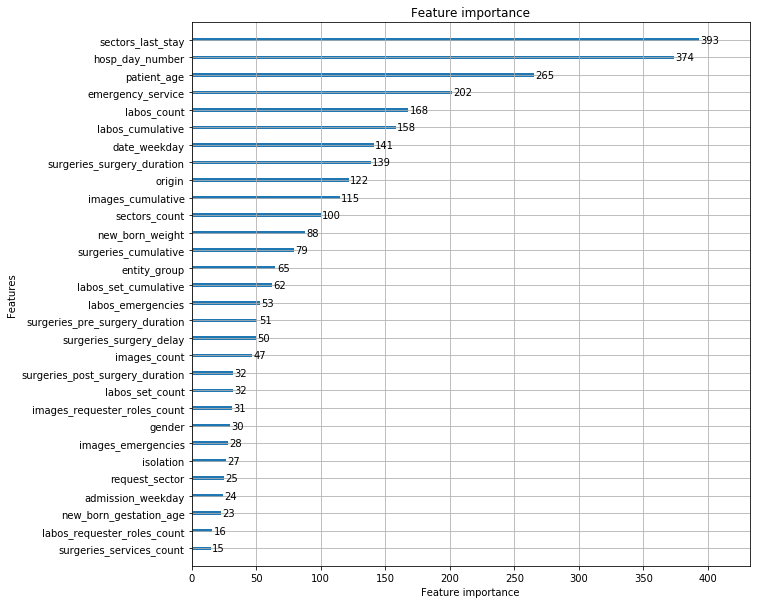

In [42]:
lgb.plot_importance(bst, figsize=(10,10),max_num_features=30, importance_type='split')

By looking at this chart we confirm some of our hints about variables that we expected to perform very well (as age and origin). 
We also see that the model has find some obvious relationships and its taking advantage of them (for example, how many days the patient's has already been hospitalized seems crucial to predict whether it will continue or not).
Finally the learning has unconvered some important patterns that weren't so clear for us. For example the variable 'sector_last_stay'  which refers to the sector where the patient is currently hospitalized ends up being the most important one. 

It is necessary to clarify that this chart does not say anything about the direction of the relationship with the target variable. Moreover, as we are working with decision trees, relationships might very well not be linear, meaning that sometimes is the combination of certain feature values that lets the model predict in a certain way.
Later on, further analysis will be done in the model output in order to understand the impact certain variables have on the model predictions as we do not want the model to be a black box, specially considering the sensitivity of the problem at stake.